In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import astropy.units as u
import astropy.constants as cr
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt
import matplotlib
from astroduet.config import Telescope
from astroduet.filters import load_qe, load_reflectivity, load_redfilter, load_transmission, apply_trans
from astroduet.background import airglow_lines
from astroduet.zodi import load_airglow, load_zodi

In [2]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = [15,8]
plotcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
duet = Telescope()
# Background spectrum
zodi = load_zodi(scale=77, airglow=False)
no_airglow = zodi['flux'].copy()
airglow_lines = airglow_lines(zodi['wavelength'])
zodi['flux'] += airglow_lines
# Flat spectrum
flat = {'wavelength': zodi['wavelength'], 'flux': [1]*len(zodi['flux'])*zodi['flux'].unit}

# Load filters, transmission and stuff
ref_wave, reflectivity = load_reflectivity(duet.reflectivity_file['name'], diag=True)
trans_wave, transmission = load_transmission(duet.transmission_file)
pixel_area = duet.pixel **2
qe_wave1, qe1 = load_qe(duet.qe_files['names'][0])
qe_wave2, qe2 = load_qe(duet.qe_files['names'][1])
red_wave1, red_trans1 = load_redfilter(duet.bandpass_files['names'][0], filter_type='B')
red_wave2, red_trans2 = load_redfilter(duet.bandpass_files['names'][1], filter_type='B')

Optics reflectivity loader
Input file /Users/mheida/scripts/git/duet-astro/astroduet/data/mirror_coatings_20190518.csv


In [4]:
print(duet.band1)
print(duet.band2)

{'eff_wave': <Quantity 198.63858525 nm>, 'eff_width': <Quantity 31.00790249 nm>}
{'eff_wave': <Quantity 280.56077333 nm>, 'eff_width': <Quantity 51.25641246 nm>}


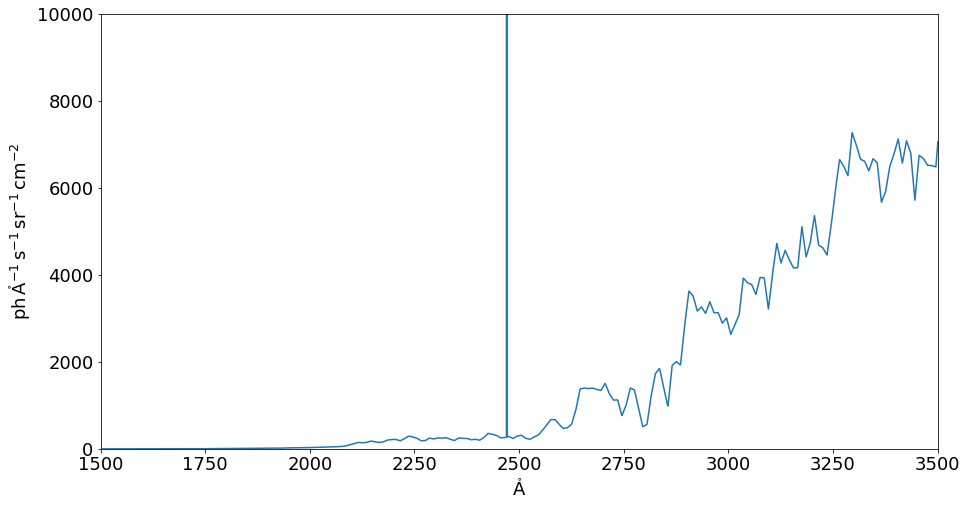

In [5]:
with quantity_support():
    plt.plot(zodi['wavelength'], zodi['flux'])
    plt.ylim(0,1e4)
    plt.xlim(1500,3500)

In [25]:
flat['flux_t'] = apply_trans(flat['wavelength'], flat['flux'], trans_wave, transmission)
flat['flux_tr'] = apply_trans(flat['wavelength'], flat['flux_t'], ref_wave, reflectivity)
flat['flux_trq'] = apply_trans(flat['wavelength'], flat['flux_tr'], qe_wave1, qe1)
flat['flux_trqf'] = apply_trans(flat['wavelength'], flat['flux_trq'], red_wave1, red_trans1)

flat['flux_trq2'] = apply_trans(flat['wavelength'], flat['flux_tr'], qe_wave2, qe2)
flat['flux_trqf2'] = apply_trans(flat['wavelength'], flat['flux_trq2'], red_wave2, red_trans2)

Text(0, 0.5, 'Troughput')

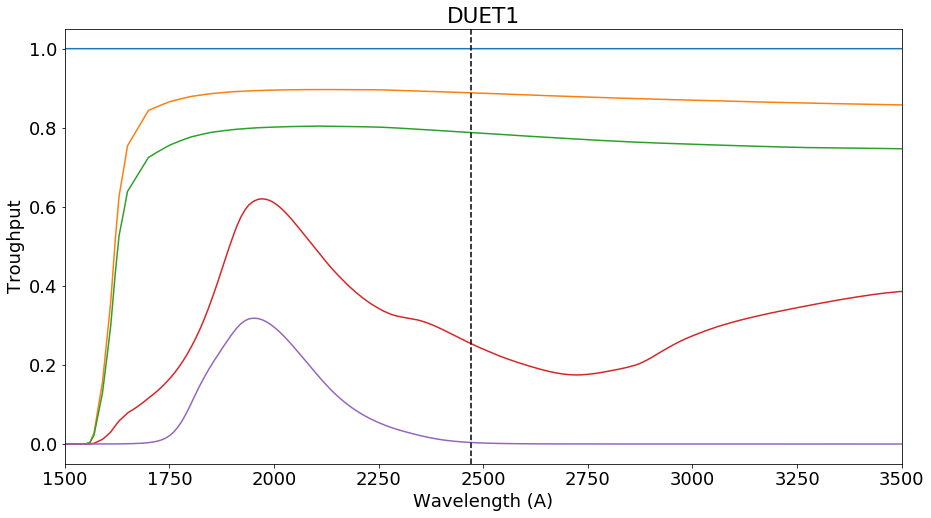

In [27]:
plt.plot(flat['wavelength'], flat['flux'])
plt.plot(flat['wavelength'], flat['flux_t'])
plt.plot(flat['wavelength'], flat['flux_tr'])
plt.plot(flat['wavelength'], flat['flux_trq'])
plt.plot(flat['wavelength'], flat['flux_trqf'])

plt.axvline(x=2470, ymin=0, ymax=1, color='black', linestyle='--')
plt.xlim(1500, 3500)
plt.title('DUET1')
plt.xlabel('Wavelength (A)')
plt.ylabel('Troughput')

Text(0, 0.5, 'Troughput')

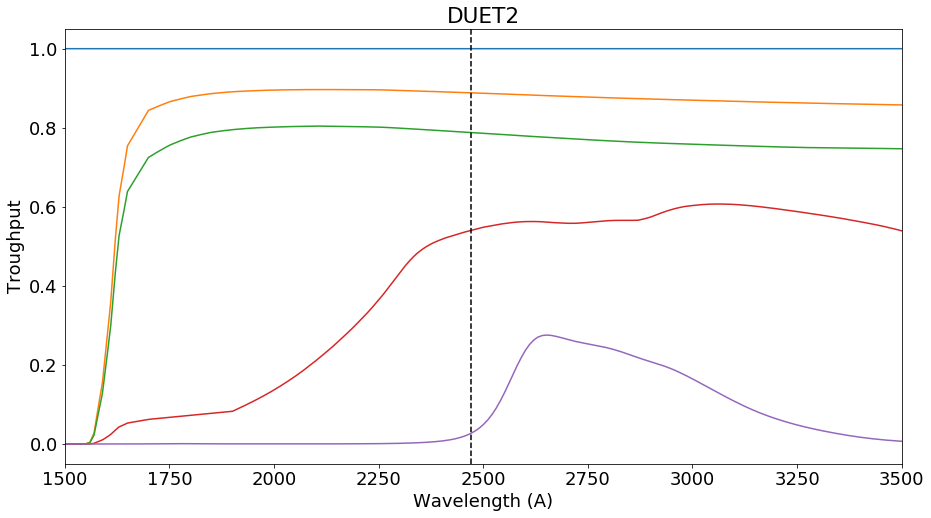

In [28]:
plt.plot(flat['wavelength'], flat['flux'])
plt.plot(flat['wavelength'], flat['flux_t'])
plt.plot(flat['wavelength'], flat['flux_tr'])
plt.plot(flat['wavelength'], flat['flux_trq2'])
plt.plot(flat['wavelength'], flat['flux_trqf2'])

plt.axvline(x=2470, ymin=0, ymax=1, color='black', linestyle='--')
plt.xlim(1500, 3500)
plt.title('DUET2')
plt.xlabel('Wavelength (A)')
plt.ylabel('Troughput')

In [31]:
# Throughput of [OII] line in filter 1:
print(flat['flux_trqf'][flat['wavelength'].value == 2470].value[0])

0.00389003281739907


In [32]:
# Throughput of [OII] line in filter 2:
print(flat['flux_trqf2'][flat['wavelength'].value == 2470].value[0])

0.026582505183103226
